# SETUP

# Load env variables

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables (needed here and by llm_parser)
load_dotenv()

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
LANGSMITH_API_KEY = os.environ.get("LANGSMITH_API_KEY")

MODEL_NAME = 'gpt-4o-mini'

#MODEL_NAME =  "openai:gpt-5"

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

# Define the runtime context to provide the agent and tools with access to the database

In [3]:

from dataclasses import dataclass

@dataclass
class RuntimeContext:
    db: SQLDatabase

In [4]:
from langchain_core.tools import tool
from langgraph.runtime import  get_runtime

@tool
def execute_sql(query:str) -> str:
    """Execute a SQL Lite command and return results"""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"


# ADD A SYSTEM PROMPT TO DEFINE THE AGENTS BEHAVIOR

In [5]:
SYSTEM_PROMPT = """ You are a careful SQLite Analyst

Rules:
 - Think Step-by-Step.
 - When you need data, call the tool `execute_sql` with one SELECT query.
 - Read-Only only; No INSERT/UPDATE/DELETE/ALTER/DROP/TRUNCATE/CREATE/REPLACE.
 - Limit to 5 rows of output unless the user explicitely asks otherwise.
 - if the tool returns 'Error:', revise the SQL and try again
 - Prefer explicit column lists; avoid SELECT *
 - If you are getting wrong answer you can always list the tables in the db and check within those tables 
"""

# CREATE YOUR AGENT! ADD A MODEL, TOOL, A PROMPT AND THE RUNTIME ACCESS AND GO! 

In [6]:
from langchain.agents import create_agent

agent = create_agent(
    model= MODEL_NAME ,
    tools=[execute_sql],
    system_prompt = SYSTEM_PROMPT,
    context_schema = RuntimeContext,
)

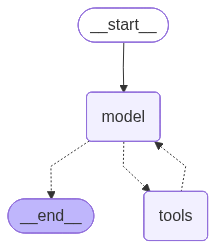

In [7]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Run some Queries 
 - Agent does not have the database schema and will need to discover it independently
 - the agent may make mistakes! by returning error messages, the agent can self-correct its queries
 - notice you invoke agent with agent.stream
   - this command and the poretty_orint display the messages that communicate information between the model and tools
 - notice the agent doesnt remember the schema between invocations

In [8]:
question = "Which table has the largest number of entries"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
): 
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_pLpSaauLshJtkW5OMfiW6437)
 Call ID: call_pLpSaauLshJtkW5OMfiW6437
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_jmK3t9Usxp0l7sRyqKmrlMsC)
 Call ID: call_jmK3t9Usxp0l7sRyqKmrlMsC
  Args:
    query: SELECT COUNT(*) as entry_count FROM Album;
  execute_sql (call_rxFREWVVX0vqCRvXRrXjuF4Q)
 Call ID: call_rxFREWVVX0vqCRvXRrXjuF4Q
  Args:
    query: SELECT COUNT(*

In [9]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
): 
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_DPoIFzlP1T0RDgKctmXnk6lC)
 Call ID: call_DPoIFzlP1T0RDgKctmXnk6lC
  Args:
    query: SELECT genre, AVG(track_length) AS average_track_length FROM tracks GROUP BY genre ORDER BY average_track_length DESC LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: tracks
[SQL: SELECT genre, AVG(track_length) AS average_track_length FROM tracks GROUP BY genre ORDER BY average_track_length DESC LIMIT 1;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_wOu0gw1KeT8Ix37gzcEx5fsy)
 Call ID: call_wOu0gw1KeT8Ix37gzcEx5fsy
  Args:
    quer

In [10]:
question = "Please list all the tables?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
): 
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all the tables?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_ufVMW8knUVTt71ZseWut4AmD)
 Call ID: call_ufVMW8knUVTt71ZseWut4AmD
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

The tables in the database are:

1. Album
2. Artist
3. Customer
4. Employee
5. Genre
6. Invoice
7. InvoiceLine
8. MediaType
9. Playlist
10. PlaylistTrack
11. Track


In [11]:
question = "Do you know the customer called Frank Harris"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
): 
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Do you know the customer called Frank Harris
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_xzfNScd7s5GG15BAa6xYJ7jt)
 Call ID: call_xzfNScd7s5GG15BAa6xYJ7jt
  Args:
    query: SELECT * FROM customers WHERE name = 'Frank Harris' LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: customers
[SQL: SELECT * FROM customers WHERE name = 'Frank Harris' LIMIT 5;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_5vjH6IM1UGlw0ql2IW8QiXQM)
 Call ID: call_5vjH6IM1UGlw0ql2IW8QiXQM
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message ==============================